# Final Model

### Prepping Data

In [2]:
import sys
sys.dont_write_bytecode = True
%load_ext autoreload 
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from preprocesing import prepData

path = '../data/bike.csv'
df = pd.read_csv(path, encoding_errors='ignore', parse_dates=['Date'], dayfirst=True)
pd.set_option('display.max_columns', None) # lets you scroll if your monitor isn't wide enough
df = prepData(df)
display(df)

,Rented Bike Count,Temperature(C),Wind Speed(m/s),Solar Radiation(MJ/m2),Rainfall(mm),Spring,Summer,Autumn,Winter,Weekend,Summer*Temp
Date,,,,,,,,,,,
2017-12-01,9539,-2.454167,1.537500,1.16,0.0,0,0,0,1,0,-0.0
2017-12-02,8523,1.325000,1.712500,1.12,0.0,0,0,0,1,1,0.0
2017-12-03,7222,4.875000,1.612500,0.69,4.0,0,0,0,1,1,0.0
2017-12-04,8729,-0.304167,3.450000,1.17,0.1,0,0,0,1,0,-0.0
2017-12-05,8307,-4.458333,1.108333,0.64,0.0,0,0,0,1,0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-11-26,17162,6.320833,1.029167,1.74,0.0,0,0,1,0,0,0.0
2018-11-27,16282,7.066667,1.350000,0.87,0.0,0,0,1,0,0,0.0
2018-11-28,16524,5.304167,1.695833,1.86,0.0,0,0,1,0,0,0.0


In [3]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split

y = df['Rented Bike Count'].to_numpy() # our target value
X = df.drop('Rented Bike Count', axis=1) # our features

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle=True, random_state=1)

# normalizing our target value
y_transformer = QuantileTransformer(output_distribution='normal', random_state=1)
y_train = y_transformer.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test = y_transformer.transform(y_test.reshape(-1, 1)).ravel()

c:\Users\oo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (247). n_quantiles is set to n_samples.
  warnings.warn(


### Evaluation

In [4]:
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import clear_output

def finalTest(model):
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # creating the regression equation
    feature_names = X_train.columns
    coefs = model.coef_

    reg_equation = f"QuantileTransformation(BikeCount) = {model.intercept_:.2f}"
    for i, coef in enumerate(coefs):
        if coef > 0:
            reg_equation += f' + {coef:.2f}*{feature_names[i]}'
        else:
            reg_equation += f' - {abs(coef):.2f}*{feature_names[i]}'
            
    # convert our predictions back into normal space
    train_pred_original = y_transformer.inverse_transform(train_pred.reshape(-1,1))
    test_pred_original = y_transformer.inverse_transform(test_pred.reshape(-1,1))
    y_train_original = y_transformer.inverse_transform(y_train.reshape(-1,1))
    y_test_original = y_transformer.inverse_transform(y_test.reshape(-1,1))

    # gathering metrics    
    r2_train = r2_score(y_train_original, train_pred_original)
    r2_test = r2_score(y_test_original, test_pred_original)
    mse_test = mean_squared_error(y_test_original, test_pred_original)
    mse_train = mean_squared_error(y_train_original, train_pred_original)
    rmse_test = np.sqrt(mse_test)
    rmse_train = np.sqrt(mse_train)

    clear_output(True)
    print(f"Regression Equation:\n{reg_equation}")
    print(f"Test Accuracy: {r2_test * 100:.2f}%")
    print(f"Train Accuracy: {r2_train * 100:.2f}%")
    print(f"Accuracy Difference: {(r2_test - r2_train) * 100:.2f}%")
    print(f"Test Mean Squared Error: {mse_test:.2f}")
    print(f"Train Mean Squared Error: {mse_train:.2f}")
    print(f"Test Root Mean Squared Error: {rmse_test:.2f}")
    print(f"Train Root Mean Squared Error: {rmse_train:.2f}")

    # Visualizing
    sns.set_theme(style='darkgrid')
    fig, ax = plt.subplots(2, 2, figsize=(20,13))
    ax[0,0].set_title('Predicted vs Actual for Test Set')
    ax[0,0].scatter(y_test_original, test_pred_original, color='blue', label='Predicted vs Actual')
    ax[0,0].plot(y_test_original, y_test_original, color='red', label='Ideal')
    ax[0,0].legend()
    ax[0,0].set_xlabel('Actual')
    ax[0,0].set_ylabel('Predicted')

    ax[0,1].set_title('Predicted vs Actual for Train Set')
    ax[0,1].scatter(y_train_original, train_pred_original, color='green', label='Predicted vs Actual')
    ax[0,1].plot(y_train_original, y_train_original, color='red', label='Ideal')
    ax[0,1].legend()
    ax[0,1].set_xlabel('Actual')
    ax[0,1].set_ylabel('Predicted')

    test_residuals = y_test_original.reshape(-1,1) - test_pred_original.reshape(-1,1)
    ax[1,0].set_title('Residual Plot for Test Set')
    ax[1,0].scatter(test_pred_original, test_residuals, color='blue')
    ax[1,0].axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
    ax[1,0].legend()
    ax[1,0].set_xlabel("Fitted")
    ax[1,0].set_ylabel("Residuals")

    train_residuals = y_train_original.reshape(-1,1) - train_pred_original.reshape(-1,1)
    ax[1,1].set_title('Residual Plot for Train Set')
    ax[1,1].scatter(train_pred_original, train_residuals, color='green')
    ax[1,1].axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
    ax[1,1].legend()
    ax[1,1].set_xlabel("Fitted")
    ax[1,1].set_ylabel("Residuals")
    
    plt.show()

Regression Equation:
QuantileTransformation(BikeCount) = -0.38 + 0.06*Temperature(C) - 0.06*Wind Speed(m/s) + 0.27*Solar Radiation(MJ/m2) - 0.03*Rainfall(mm) - 0.61*Spring + 1.58*Summer - 0.28*Autumn - 0.69*Winter - 0.24*Weekend - 0.09*Summer*Temp
Test Accuracy: 88.95%
Train Accuracy: 89.19%
Accuracy Difference: -0.24%
Test Mean Squared Error: 10605637.91
Train Mean Squared Error: 10750063.47
Test Root Mean Squared Error: 3256.63
Train Root Mean Squared Error: 3278.73


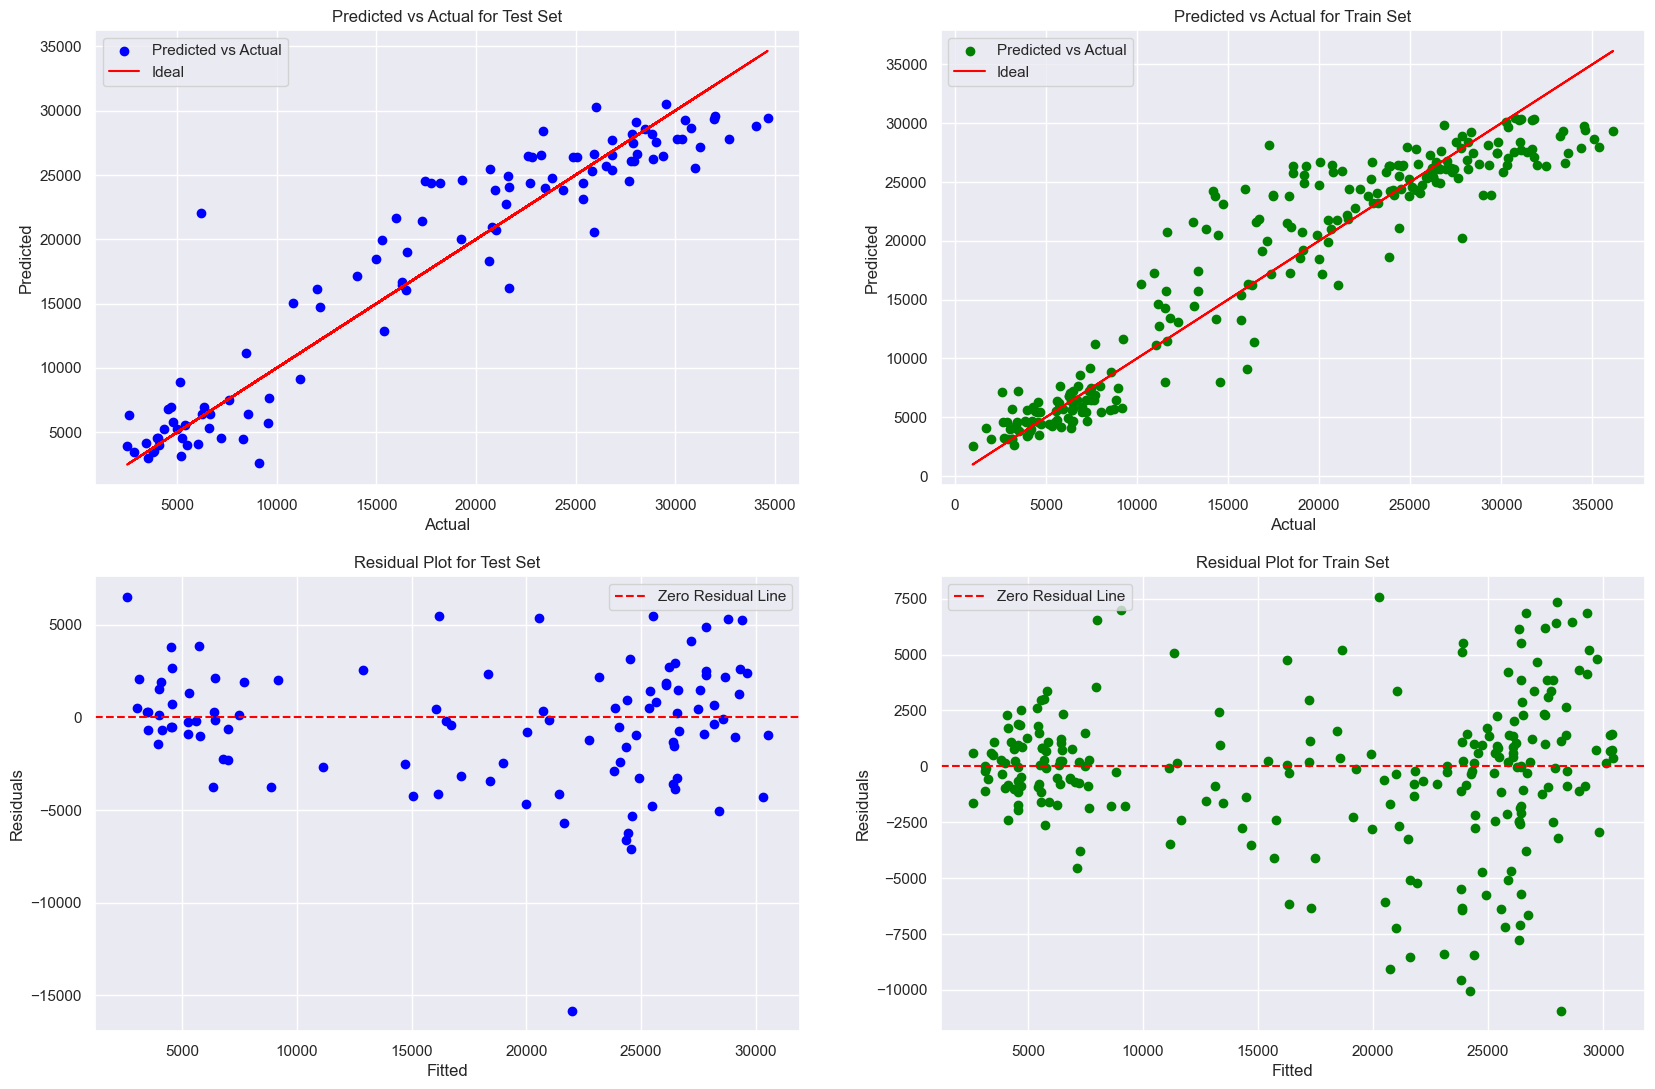

In [6]:
from sklearn.linear_model import HuberRegressor
finalTest(HuberRegressor(alpha=5, epsilon=1.668503, max_iter=1000))